In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import cv2
import nibabel as nib
from scipy import ndimage
import tensorflow as tf
import scipy
from scipy.stats import wilcoxon
from scipy.ndimage.measurements import label

In [4]:
#save the image slices, masks, and information about one-click

posPatients = np.concatenate((np.array([2,4,5,7,9,11,12,13,16,17,18,19,21,22]),range(23,52),np.array([55]),
                                range(60,63),range(64,74),range(75,82),range(83,104),range(105,109)))
locList = []
maskList = []
posList = []

img_height=64
limit=0.25
pixLimit=5

comList = []
pixList = []

for i in range(len(posPatients)):
    if posPatients[i]<23:
        if posPatients[i]==12:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/12_anon/12_maski/12_maskit.img'
        else:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_maski/{}_maski.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    else:
        if posPatients[i]==23:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/23/23_maski/23_nifti_maski_edit.img'
        if posPatients[i]==24:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/24/24_maski/24_maski.img'
        if posPatients[i]==38:
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/38/38_nifti_maski/38_nifti_maski_edit.img'
        if posPatients[i] not in [23,24,38]:    
            img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}/{}_nifti_maski/{}_nifti_maski.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    locations = []
    masks = []
    for j in range(img_data.shape[2]):
        slice = np.array(img_data[:,:,j])
        if np.max(slice)>0:
            slice=cv2.resize(slice,(img_height,img_height))
            for k in range(img_height):
                for l in range(img_height):
                    if slice[k,l]>limit:
                        slice[k,l]=1
                    else:
                        slice[k,l]=0
            if np.sum(slice)>pixLimit:
                locations.append(j)
                masks.append(slice)
    locList.append(np.array(locations))
    maskList.append(masks)

for i in range(len(posPatients)):
    if posPatients[i]<23:
        img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}_anon/{}_nifti_pet/{}_nifti_pet.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    else:
        img_path = 'C:/Users/Oona/Documents/Tpc/hnc/anom_data/positiiviset/{}/{}_nifti_pet/{}_nifti_pet.img'.format(
                        posPatients[i],posPatients[i],posPatients[i])
    img = nib.load(img_path)
    img_data = img.get_fdata()
    pos = []
    for j in range(len(locList[i])):
        pos.append(cv2.resize(np.array(img_data[:,:,locList[i][j]]),(img_height,img_height)))
    posList.append(pos)

for i in range(len(posPatients)):
    comImgs=[]
    for j in range(len(maskList[i])):
        img=maskList[i][j]
        com=ndimage.measurements.center_of_mass(img)
        img1=np.zeros((img_height,img_height))
        img1[round(com[0]),round(com[1])]=1
        comImgs.append(img1)
    comList.append(comImgs)

np.random.seed(131)
for i in range(len(posPatients)):
    pixImgs=[]
    for j in range(len(maskList[i])):
        img=maskList[i][j]
        options=[]
        for k in range(img_height):
            for l in range(img_height):
                if img[k,l]==1:
                    options.append(np.array([k,l]))
        img1=np.zeros((img_height,img_height))
        onePix=random.choice(options)
        img1[onePix[0],onePix[1]]=1
        pixImgs.append(img1)
    pixList.append(pixImgs)

In [5]:
numberOfSlices=[]
finPatients=0
for i in range(len(posList)):
    numberOfSlices.append(len(posList[i]))
    if len(posList[i])>0:
        finPatients+=1
numberOfSlices=np.array(numberOfSlices)
print(finPatients)
print(sum(numberOfSlices))
print(np.mean(numberOfSlices))
print(np.std(numberOfSlices))
print(numberOfSlices)

79
767
8.617977528089888
5.97843619020843
[ 1  9  9 13  6  7 13  9  1 10 12  6 10  9  4 12  2  2  6  4  6  4  4 10
 12  5 12 12  0 18  7 10 12 21 10  3 18  0 12 21  4  6  0  9  6 13 20  9
  7 13 19  0  5  7  5  2  0  0  0  3 17 15  6 20 20 11  3 10  4  6  0  4
 15  5 23  0 10  9 20  5 15 12 18  8 12  8  0  8 13]


In [6]:
#convert images into typical format

def convert(img):

    img=(img-np.min(img))/(np.max(img)-np.min(img))*255
    for i in range(64):
        for j in range(64):
            img[i,j]=int(img[i,j])
    return img.astype('int64')

for i in range(len(posList)):
    for j in range(len(posList[i])):
        posList[i][j]=convert(posList[i][j])

In [7]:
#create train and test data sets for image data and one-click information (x) and correct masks (y)

def splitIntoSets(posList,maskList,comList,pixList,testSetIndexes,type,k):

    #type is 'com' for center of mass, 'pix' for random positive pixel, and 'no' if neither

    x_train = []
    y_train = []
    x_test = []
    y_test = []
    img_height=64

    testSetPatients=testSetIndexes[k]

    for i in range(len(posList)):
        if i in testSetPatients:
            for j in range(len(posList[i])):
                img=(posList[i][j]-np.min(posList[i][j]))/(np.max(posList[i][j])-np.min(posList[i][j]))
                if type=='com':
                    x_test.append(np.rollaxis(np.array([img,comList[i][j]]),0,3))
                if type=='pix':
                    x_test.append(np.rollaxis(np.array([img,pixList[i][j]]),0,3))
                if type=='no':
                    x_test.append(img)
                y_test.append(cv2.resize(maskList[i][j],(img_height,img_height)))   
        else:
            for j in range(len(posList[i])):
                img=(posList[i][j]-np.min(posList[i][j]))/(np.max(posList[i][j])-np.min(posList[i][j]))
                if type=='com':
                    x_train.append(np.rollaxis(np.array([img,comList[i][j]]),0,3))
                if type=='pix':
                    x_train.append(np.rollaxis(np.array([img,pixList[i][j]]),0,3))
                if type=='no':
                    x_train.append(img)
                y_train.append(cv2.resize(maskList[i][j],(img_height,img_height)))  

    x_train=np.array(x_train)
    y_train=np.array(y_train)
    x_test=np.array(x_test)
    y_test=np.array(y_test)

    return([x_train,y_train,x_test,y_test])

#Unet CNN for segmentation

def unetForSegmentation(shape):

    img_height=shape[1]
    if len(shape)==4:
        chl_number=shape[3]
    else:
        chl_number=1

    #U-Net model
    inputs = tf.keras.layers.Input(shape=(img_height,img_height,chl_number))

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

    #Expansive path
    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='linear')(c9) #sigmoid or linear

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy')

    return model

#count the dice scores between predictions converted into binary with limit and y_test (real mask of the test set)

def dicesForLimit(predictions,y_test,limit):

    dices=np.zeros((len(y_test)))

    img_height=predictions[0].shape[0]

    for k in range(len(y_test)):
        TP=0
        FN=0
        FP=0
        for i in range(img_height):
            for j in range(img_height):
                if y_test[k,i,j]>0.5 and predictions[k,i,j]>limit:
                    TP+=1
                if y_test[k,i,j]>0.5 and predictions[k,i,j]<limit:
                    FN+=1
                if y_test[k,i,j]<0.5 and predictions[k,i,j]>limit:
                    FP+=1
        if TP+FN+FP>0:
            dices[k]=2*TP/(2*TP+FN+FP)

    return(dices)

#find the best limit to convert predictions into binary

def optimizeDiceLimit(predictions,y_test):

    potLimits=0.01*np.array(range(0,100))
    medianDices = []

    for i in range(len(potLimits)):
        medianDices.append(np.median(dicesForLimit(predictions,y_test,potLimits[i])))

    limit=potLimits[medianDices.index(max(medianDices))]

    return(limit)

#create one binary mask

def turnIntoBinaryMask(img,lim):

    img_height=img.shape[0]

    binM=np.zeros((img_height,img_height))

    for i in range(img_height):
        for j in range(img_height):
            if img[i][j]>lim:
                binM[i][j]=1
    
    return binM

#algorithm for removing segmentation further away from the one-click pixel

def removePixels(predictions,x_test,limit):

    predictions1=[]

    for k in range(len(predictions)):

        img=turnIntoBinaryMask(predictions[k],limit)
        ind=np.unravel_index(np.argmax(x_test[k,:,:,1],axis=None),img.shape)
        c=True

        k0=ind[0]-1
        k1=ind[0]+1
        k2=ind[1]-1
        k3=ind[1]+1

        while c:
            c=False
            if np.sum(img[k0,k2:k3])>0:
                if k0>0:
                    c=True
                k0=np.max([k0-1,0])
            if np.sum(img[k1,k2:k3])>0:
                if k1<64:
                    c=True
                k1=np.min([k1+1,63])
            if np.sum(img[k0:k1,k2])>0:
                if k2>0:
                    c=True
                k2=np.max([k2-1,0])
            if np.sum(img[k0:k1,k3])>0:
                if k3<63:
                    c=True
            k3=np.min([k3+1,63])

        for i in range(img_height):
            for j in range(img_height):
                if i<k0 or i>k1 or j<k2 or j>k3: 
                    img[i,j]=0

        predictions1.append(img)

    predictions1=np.array(predictions1)

    return(predictions1)

In [190]:
def removePixelsNew(predictions,x_test,limit):

    predictions1=[]

    for k in range(len(predictions)):

        img=turnIntoBinaryMask(predictions[k],limit)
        ind=np.unravel_index(np.argmax(x_test[k,:,:,1],axis=None),img.shape)
        structure=np.ones((3,3),dtype=int)
        labeled, ncomponents = label(img,structure)
        img1=np.zeros((64,64))
        for u in range(1,ncomponents+1):
            if labeled[ind[0],ind[1]]==u or labeled[ind[0]+1,ind[1]]==u or labeled[ind[0]-1,ind[1]]==u or labeled[ind[0],ind[1]-1]==u or labeled[ind[0]+1,ind[1]-1]==u or labeled[ind[0]-1,ind[1]-1]==u or labeled[ind[0],ind[1]+1]==u or labeled[ind[0]+1,ind[1]+1]==u or labeled[ind[0]-1,ind[1]+1]==u:
                for i in range(64):
                    for j in range(64):
                        if labeled[i,j]==u:
                            img1[i,j]=1
        predictions1.append(img1)

    predictions1=np.array(predictions1)

    return(predictions1)

In [8]:
#choose testSetIndexes

testSet1=np.concatenate((range(0,70,5),np.array([72,82])))
testSet2=np.concatenate((range(1,70,5),np.array([81,83,71,88])))
testSet3=np.concatenate((range(2,70,5),np.array([75,74,77,76,80,73])))
testSet4=np.concatenate((range(3,70,5),np.array([78,84,79])))
testSet5=np.concatenate((range(4,70,5),np.array([70,85,86,87])))

testSetSlices=np.zeros((5))
testSetIndexes=[testSet1,testSet2,testSet3,testSet4,testSet5]
testSetGroups=np.zeros((5))
for j in range(5):
    for i in range(len(posList)):
        if i in testSetIndexes[j]:
            testSetSlices[j]+=len(posList[i])
            if len(posList[i])>0:
                testSetGroups[j]+=1

print(testSetGroups)
print(testSetSlices)

[16. 16. 16. 15. 16.]
[152. 155. 150. 156. 154.]


In [9]:
k=0
x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetIndexes,'no',k)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(615, 64, 64)
(615, 64, 64)
(152, 64, 64)
(152, 64, 64)


Epoch 1/100
14/14 [==============================] - 16s 886ms/step - loss: 0.2230 - val_loss: 0.0891
Epoch 2/100
14/14 [==============================] - 12s 861ms/step - loss: 0.1049 - val_loss: 0.0846
Epoch 3/100
14/14 [==============================] - 12s 884ms/step - loss: 0.0918 - val_loss: 0.0628
Epoch 4/100
14/14 [==============================] - 13s 938ms/step - loss: 0.0801 - val_loss: 0.0467
Epoch 5/100
14/14 [==============================] - 12s 810ms/step - loss: 0.0623 - val_loss: 0.0397
Epoch 6/100
14/14 [==============================] - 15s 1s/step - loss: 0.0559 - val_loss: 0.0346
Epoch 7/100
14/14 [==============================] - 14s 1s/step - loss: 0.0532 - val_loss: 0.0295
Epoch 8/100
14/14 [==============================] - 11s 790ms/step - loss: 0.0450 - val_loss: 0.0272
Epoch 9/100
14/14 [==============================] - 10s 722ms/step - loss: 0.0416 - val_loss: 0.0264
Epoch 10/100
14/14 [==============================] - 10s 721ms/step - loss: 0.0377 - va

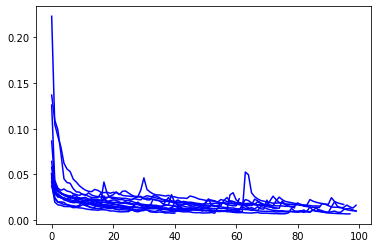

In [178]:
for k in range(5):
    for j in ['no','com','pix']:
        x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetIndexes,j,k)
        model=unetForSegmentation(x_test.shape)
        numEpochs=100
        earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=30, restore_best_weights=True)
        history=model.fit(x=x_train,y=y_train,epochs=numEpochs,validation_split=0.3,callbacks=[earlystopping],shuffle=True)
        trainPredictions=model.predict(x_train)
        predictions=model.predict(x_test)
        plt.plot(range(len(history.history['loss'])),history.history['loss'],color='blue')
        for i in range(len(trainPredictions)):
            np.savetxt('{}_{}_{}_trainPredictions.txt'.format(j,k,i), trainPredictions[i][:,:,0])
        for i in range(len(predictions)):
            np.savetxt('{}_{}_{}_predictions.txt'.format(j,k,i), predictions[i][:,:,0])

In [187]:
predictions1=[]

for k in range(len(predictions)):
    img=turnIntoBinaryMask(predictions[k],limit)
    ind=np.unravel_index(np.argmax(x_test[k,:,:,1],axis=None),img.shape)
    structure=np.ones((3,3),dtype=int)
    labeled, ncomponents = label(img,structure)
    img1=np.zeros((64,64))
    f=0
    for u in range(1,ncomponents+1):
        if labeled[ind[0],ind[1]]==u or labeled[ind[0]+1,ind[1]]==u or labeled[ind[0]-1,ind[1]]==u or labeled[ind[0],ind[1]-1]==u or labeled[ind[0]+1,ind[1]-1]==u or labeled[ind[0]-1,ind[1]-1]==u or labeled[ind[0],ind[1]+1]==u or labeled[ind[0]+1,ind[1]+1]==u or labeled[ind[0]-1,ind[1]+1]==u:
            print(k,':found in comp.',u)
            f=1
            #for i in range(64):
                #for j in range(64):
                    #if labeled[i,j]==u:
                        #img1[i,j]=1
    if f==0:
        print(k,':not found')
    #predictions1.append(img1)

#predictions1=np.array(predictions1)

0 :not found
1 :found in comp. 2
2 :found in comp. 2
3 :found in comp. 2
4 :found in comp. 2
5 :found in comp. 2
6 :found in comp. 1
7 :found in comp. 1
8 :found in comp. 1
9 :found in comp. 1
10 :found in comp. 1
11 :not found
12 :not found
13 :not found
14 :found in comp. 1
15 :found in comp. 1
16 :found in comp. 1
17 :found in comp. 1
18 :found in comp. 1
19 :found in comp. 1
20 :found in comp. 1
21 :found in comp. 1
22 :found in comp. 1
23 :found in comp. 1
24 :found in comp. 1
25 :found in comp. 1
26 :found in comp. 1
27 :found in comp. 1
28 :found in comp. 1
29 :found in comp. 1
29 :found in comp. 2
30 :not found
31 :found in comp. 1
32 :found in comp. 1
33 :found in comp. 1
34 :found in comp. 1
35 :found in comp. 1
36 :found in comp. 1
37 :found in comp. 1
38 :found in comp. 1
39 :found in comp. 1
40 :found in comp. 1
41 :not found
42 :not found
43 :not found
44 :found in comp. 2
45 :found in comp. 1
46 :found in comp. 1
47 :not found
48 :found in comp. 1
49 :found in comp. 1
50

In [124]:
k=4
j='pix'
x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetIndexes,j,k)
trainPredictions=[]
for i in range(len(x_train)):
    trainPredictions.append(np.loadtxt('{}_{}_{}_trainPredictions.txt'.format(j,k,i)))
trainPredictions=np.array(trainPredictions)
predictions=[]
for i in range(len(x_test)):
    predictions.append(np.loadtxt('{}_{}_{}_predictions.txt'.format(j,k,i)))
predictions=np.array(predictions)

In [134]:
#print the results by using predictions of the training data to find limit for converting test set predictions into binary

#lim=optimizeDiceLimit(trainPredictions,y_train)
lim=0.34
print(lim)
print('Train set:')
dices=dicesForLimit(trainPredictions,y_train,lim)
print(np.round(np.median(dices),3))
#print(np.round(np.percentile(dices,75)-np.percentile(dices,25),3))
print(np.round(np.mean(dices),3))
print(np.round(np.std(dices),3))

0.34
Train set:
0.778
0.722
0.189


In [137]:
noLims=[0.12,0.27,0.18,0.19,0.23]
comLims=[0.37,0.3,0.31,0.3,0.38]
pixLims=[0.37,0.41,0.46,0.32,0.33]

for k in range(5):
    j='no'
    x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetIndexes,j,k)
    predictions=[]
    for i in range(len(x_test)):
        predictions.append(np.loadtxt('{}_{}_{}_predictions.txt'.format(j,k,i)))
    predictions=np.array(predictions)
    lim=noLims[k]
    dices=dicesForLimit(predictions,y_test,lim)
    np.savetxt('no_dices_{}.txt'.format(k),dices)
    j='com'
    x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetIndexes,j,k)
    predictions=[]
    for i in range(len(x_test)):
        predictions.append(np.loadtxt('{}_{}_{}_predictions.txt'.format(j,k,i)))
    predictions=np.array(predictions)
    lim=comLims[k]
    dices=dicesForLimit(predictions,y_test,lim)
    np.savetxt('com_dices_{}.txt'.format(k),dices)
    j='pix'
    x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetIndexes,j,k)
    predictions=[]
    for i in range(len(x_test)):
        predictions.append(np.loadtxt('{}_{}_{}_predictions.txt'.format(j,k,i)))
    predictions=np.array(predictions)
    lim=pixLims[k]
    dices=dicesForLimit(predictions,y_test,lim)
    np.savetxt('pix_dices_{}.txt'.format(k),dices)

In [258]:
fixedNoLims=[0.08,0.23,0.17,0.15,0.23]

for k in range(5):
    j='no'
    x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetIndexes,j,k)
    predictions=[]
    for i in range(len(x_test)):
        predictions.append(np.loadtxt('{}_{}_{}_predictions.txt'.format(j,k,i)))
    predictions=np.array(predictions)
    lim=fixedNoLims[k]
    x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetIndexes,'com',k)
    predictions1=removePixelsNew(predictions,x_test,lim)
    dices=dicesForLimit(predictions1,y_test,lim)
    np.savetxt('fix_com_dices_{}.txt'.format(k),dices)
    x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetIndexes,'pix',k)
    predictions1=removePixelsNew(predictions,x_test,lim)
    dices=dicesForLimit(predictions1,y_test,lim)
    np.savetxt('fix_pix_dices_{}.txt'.format(k),dices)

In [263]:
diceList=[]

for j in ['no','com','pix','fix_com','fix_pix']:
    d0=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/{}_dices_0.txt'.format(j))
    d1=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/{}_dices_1.txt'.format(j))
    d2=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/{}_dices_2.txt'.format(j))
    d3=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/{}_dices_3.txt'.format(j))
    d4=np.loadtxt('C:/Users/Oona/Documents/Tpc/hnc/click/{}_dices_4.txt'.format(j))
    print(j)
    print(round(np.median(d0),3))
    print(round(np.median(d1),3))
    print(round(np.median(d2),3))
    print(round(np.median(d3),3))
    print(round(np.median(d4),3))
    d=np.concatenate((d0,d1,d2,d3,d4))
    print(round(np.median(d),3))
    diceList.append(d)

no
0.418
0.655
0.557
0.506
0.638
0.558
com
0.69
0.712
0.688
0.712
0.705
0.703
pix
0.625
0.667
0.673
0.705
0.704
0.68
fix_com
0.535
0.667
0.577
0.604
0.645
0.615
fix_pix
0.545
0.66
0.571
0.602
0.638
0.609


In [282]:
for j in range(5):
    print(j)
    print(round(np.std(diceList[j]),3))

0
0.278
1
0.199
2
0.201
3
0.316
4
0.304


In [271]:
print(wilcoxon(x=diceList[0],y=diceList[1]))
print(wilcoxon(x=diceList[0],y=diceList[2]))
print(wilcoxon(x=diceList[0],y=diceList[3]))
print(wilcoxon(x=diceList[0],y=diceList[4]))

WilcoxonResult(statistic=47139.0, pvalue=2.013712786178553e-57)
WilcoxonResult(statistic=39241.0, pvalue=1.60743306607526e-66)
WilcoxonResult(statistic=76944.0, pvalue=0.12414663680921571)
WilcoxonResult(statistic=77120.5, pvalue=0.15413999082526925)


In [266]:
def f_test(x,y):

    x=np.array(x)
    y=np.array(y)
    f=np.var(x,ddof=1)/np.var(y,ddof=1)
    dfn=x.size-1
    dfd=y.size-1
    p=2*min(1-scipy.stats.f.cdf(f,dfn,dfd),scipy.stats.f.cdf(f,dfn,dfd))
    return(p)

In [277]:
print(f_test(x=diceList[0],y=diceList[1]))
print(f_test(x=diceList[0],y=diceList[2]))
print(f_test(x=diceList[0],y=diceList[3]))
print(f_test(x=diceList[0],y=diceList[4]))

2.220446049250313e-16
2.220446049250313e-16
0.000375743573288874
0.012182948200047242


In [ ]:
diceList1=[diceList[0],diceList[4],diceList[3],diceList[2],diceList[1]]
fig=plt.figure(figsize=(4,4))
axi=fig.add_axes([0,0,1,1])
bplot=axi.boxplot(diceList1,patch_artist=True,positions=[1,2,3,4,5])
colors=5*['white']
for patch,color in zip(bplot['boxes'],colors):
    patch.set_facecolor(color)
for median in bplot['medians']:
    median.set(color='black',linewidth=1.5)
plt.xticks([1,2,3,4,5],['(1)','(2)','(3)','(4)','(5)'],fontsize=13)
plt.yticks(fontsize=13)
fig=plt.gcf()
plt.show()
#fig.savefig('fig_plt_5',bbox_inches='tight')

In [ ]:
x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetIndexes,'no',0)

i=3

img=x_test[i]
img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
fig.savefig('fig_b_1',bbox_inches='tight')
plt.show()

img=y_test[i]
img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
fig.savefig('fig_b_2',bbox_inches='tight')
plt.show()

predictions=[]
for j in range(len(x_test)):
    predictions.append(np.loadtxt('{}_{}_{}_predictions.txt'.format('no',0,j)))
predictions=np.array(predictions)

lim=noLims[0]
img=predictions[i]
img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
img=turnIntoBinaryMask(img,lim)
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
fig.savefig('fig_b_3',bbox_inches='tight')
plt.show()
print(diceList[0][i])

x_train,y_train,x_test,y_test=splitIntoSets(posList,maskList,comList,pixList,testSetIndexes,'com',0)
predictions1=removePixelsNew(predictions,x_test,lim)
img=predictions1[i]
img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
img=turnIntoBinaryMask(img,lim)
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
fig.savefig('fig_b_4',bbox_inches='tight')
plt.show()
print(diceList[3][i])

predictions=[]
for j in range(len(x_test)):
    predictions.append(np.loadtxt('{}_{}_{}_predictions.txt'.format('com',0,j)))
predictions=np.array(predictions)

lim=comLims[0]
img=predictions[i]
img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
img=turnIntoBinaryMask(img,lim)
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
fig.savefig('fig_b_6',bbox_inches='tight')
plt.show()
print(diceList[1][i])

predictions=[]
for j in range(len(x_test)):
    predictions.append(np.loadtxt('{}_{}_{}_predictions.txt'.format('pix',0,j)))
predictions=np.array(predictions)

lim=pixLims[0]
img=predictions[i]
img=cv2.rotate(img,cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
img=turnIntoBinaryMask(img,lim)
plt.imshow(img,cmap='gray')
fig=plt.gcf()
plt.axis('off')
fig.savefig('fig_b_5',bbox_inches='tight')
plt.show()
print(diceList[2][i])